### **About:**
- LoanTap is an online platform committed to delivering customized loan products to millennials. They innovate in an otherwise dull loan segment, to deliver instant, flexible loans on consumer friendly terms to salaried professionals and businessmen.
- The data science team at LoanTap is building an underwriting layer to determine the creditworthiness of MSMEs as well as individuals.
- LoanTap deploys formal credit to salaried individuals and businesses 4 main financial instruments:
1. Personal Loan
2. EMI Free Loan
3. Personal Overdraft
4. Advance Salary Loan

This case study will focus on the underwriting process behind Personal Loan only

### **Problem Statement:**
- Given a set of attributes for an Individual, determine if a credit line should be extended to them. If so, what should the repayment terms be in business recommendations?

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

In [96]:
data = pd.read_csv('Loantap.csv')
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

Insight:

Data dictionary:

- loan_amnt : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
- term : The number of payments on the loan. Values are in months and can be either 36 or 60.
- int_rate : Interest Rate on the loan
- installment : The monthly payment owed by the borrower if the loan originates.
- grade : LoanTap assigned loan grade
- sub_grade : LoanTap assigned loan subgrade
- emp_title :The job title supplied by the Borrower when applying for the loan.*
- emp_length : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
- home_ownership : The home ownership status provided by the borrower during registration or obtained from the credit report.
- annual_inc : The self-reported annual income provided by the borrower during registration.
- verification_status : Indicates if income was verified by LoanTap, not verified, or if the income source was verified
- issue_d : The month which the loan was funded
- loan_status : Current status of the loan - Target Variable
- purpose : A category provided by the borrower for the loan request.
- title : The loan title provided by the borrower
- dti : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LoanTap loan, divided by the borrower’s self-reported monthly income.
- earliest_cr_line :The month the borrower's earliest reported credit line was opened
- open_acc : The number of open credit lines in the borrower's credit file.
- pub_rec : Number of derogatory public records
- revol_bal : Total credit revolving balance
- revol_util : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
- total_acc : The total number of credit lines currently in the borrower's credit file
- initial_list_status : The initial listing status of the loan. Possible values are – W, F
- application_type : Indicates whether the loan is an individual application or a joint application with two co-borrowers
- mort_acc : Number of mortgage accounts.
- pub_rec_bankruptcies : Number of public record bankruptcies
- Address: Address of the individual

In [98]:
print("No. of rows : ", data.shape[0])
print("No. of columns : ", data.shape[1])

No. of rows :  396030
No. of columns :  27


In [99]:
# Checking the distribution of the outcome labels
data.loan_status.value_counts(normalize=True)*100

,proportion
loan_status,
Fully Paid,80.387092
Charged Off,19.612908


In [100]:
# Statistical summary of the dataset
data.describe(include='all')

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
count,396030.000000,396030,396030.000000,396030.000000,396030,396030,373103,377729,396030,3.960300e+05,396030,396030,396030,396030,394274,396030.000000,396030,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,396030,396030,358235.000000,395495.000000,396030
unique,NaN,2,NaN,NaN,7,35,173105,11,6,NaN,3,115,2,14,48816,NaN,684,NaN,NaN,NaN,NaN,NaN,2,3,NaN,NaN,393700
top,NaN,36 months,NaN,NaN,B,B3,Teacher,10+ years,MORTGAGE,NaN,Verified,Oct-2014,Fully Paid,debt_consolidation,Debt consolidation,NaN,Oct-2000,NaN,NaN,NaN,NaN,NaN,f,INDIVIDUAL,NaN,NaN,USCGC Smith\r\nFPO AE 70466
freq,NaN,302005,NaN,NaN,116018,26655,4389,126041,198348,NaN,139563,14846,318357,234507,152472,NaN,3017,NaN,NaN,NaN,NaN,NaN,238066,395319,NaN,NaN,8
mean,14113.888089,NaN,13.639400,431.849698,NaN,NaN,NaN,NaN,NaN,7.420318e+04,NaN,NaN,NaN,NaN,NaN,17.379514,NaN,11.311153,0.178191,1.584454e+04,53.791749,25.414744,NaN,NaN,1.813991,0.121648,NaN
std,8357.441341,NaN,4.472157,250.727790,NaN,NaN,NaN,NaN,NaN,6.163762e+04,NaN,NaN,NaN,NaN,NaN,18.019092,NaN,5.137649,0.530671,2.059184e+04,24.452193,11.886991,NaN,NaN,2.147930,0.356174,NaN
min,500.000000,NaN,5.320000,16.080000,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000e+00,0.000000,2.000000,NaN,NaN,0.000000,0.000000,NaN
25%,8000.000000,NaN,10.490000,250.330000,NaN,NaN,NaN,NaN,NaN,4.500000e+04,NaN,NaN,NaN,NaN,NaN,11.280000,NaN,8.000000,0.000000,6.025000e+03,35.800000,17.000000,NaN,NaN,0.000000,0.000000,NaN
50%,12000.000000,NaN,13.330000,375.430000,NaN,NaN,NaN,NaN,NaN,6.400000e+04,NaN,NaN,NaN,NaN,NaN,16.910000,NaN,10.000000,0.000000,1.118100e+04,54.800000,24.000000,NaN,NaN,1.000000,0.000000,NaN
75%,20000.000000,NaN,16.490000,567.300000,NaN,NaN,NaN,NaN,NaN,9.000000e+04,NaN,NaN,NaN,NaN,NaN,22.980000,NaN,14.000000,0.000000,1.962000e+04,72.900000,32.000000,NaN,NaN,3.000000,0.000000,NaN


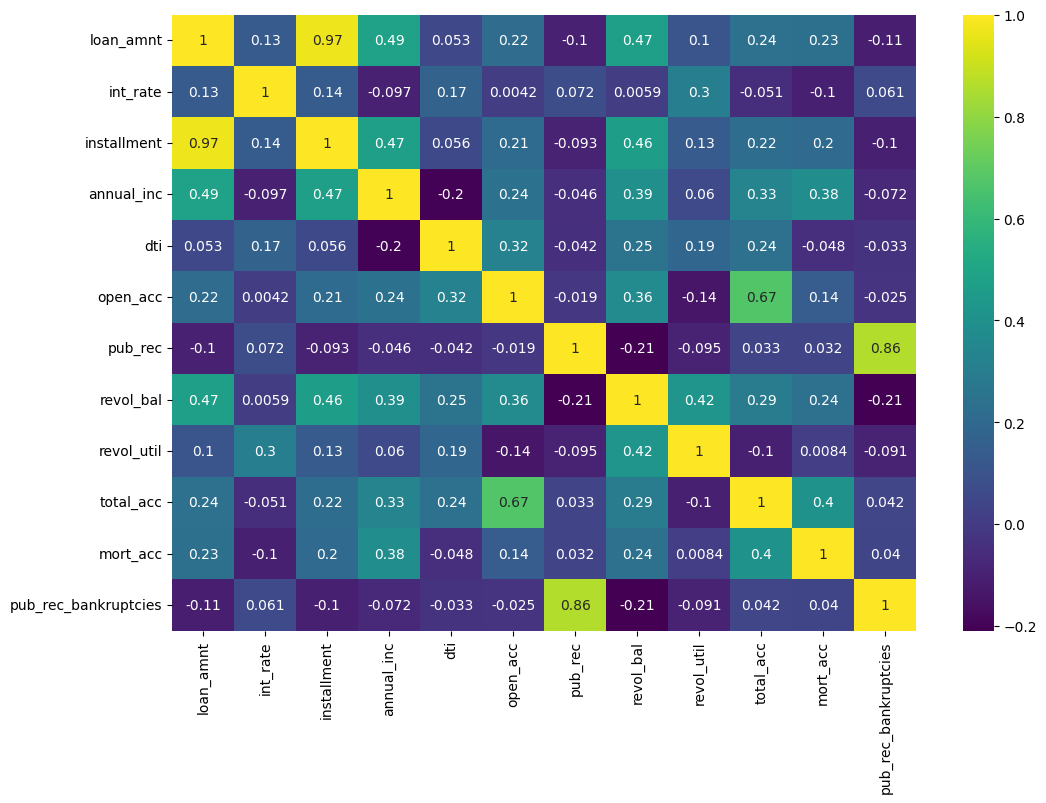

In [101]:
# Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(data.select_dtypes(include=['number']).corr(method='spearman'),annot=True,cmap='viridis') # Selecting only numeric columns for correlation calculation
plt.show()

We noticed almost perfect correlation between "loan_amnt" the "installment" feature.

- installment: The monthly payment owed by the borrower if the loan originates.
- loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

So, we can drop either one of those columns.

In [102]:
data.drop(columns=['installment'],axis=1,inplace=True)

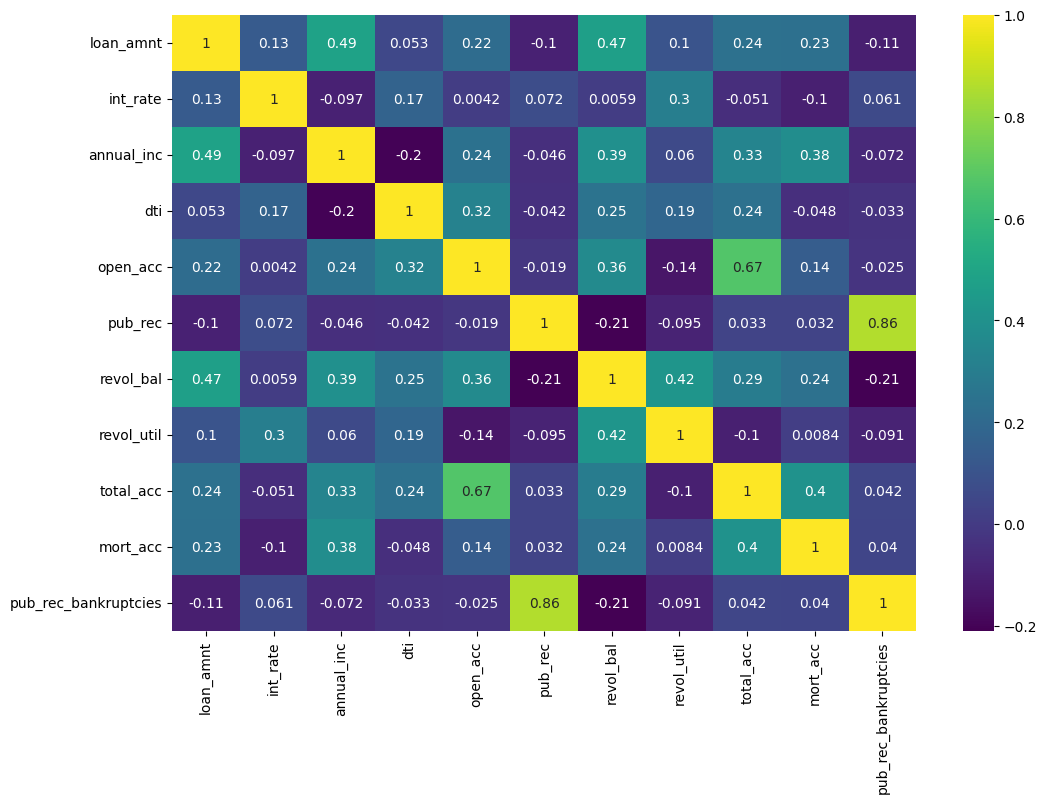

In [103]:
# Correlation Heatmap after drop the column "Installment"
plt.figure(figsize=(12,8))
sns.heatmap(data.select_dtypes(include=['number']).corr(method='spearman'),annot=True,cmap='viridis') # Selecting only numeric columns for correlation calculation
plt.show()

### **Data Exploration**
1. The no. of people who have paid fully and the no. of people who are charged off

In [104]:
data.groupby(by='loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


2. The majority of ownership as Mortgage and Rent

In [105]:
data['home_ownership'].value_counts()

,count
home_ownership,
MORTGAGE,198348
RENT,159790
OWN,37746
OTHER,112
NONE,31
ANY,3


3. Combining the minority classes as 'OTHERS'

In [106]:
data.loc[(data.home_ownership == 'ANY') | (data.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'
data.home_ownership.value_counts()

,count
home_ownership,
MORTGAGE,198348
RENT,159790
OWN,37746
OTHER,146


In [107]:
data['home_ownership'].value_counts()

,count
home_ownership,
MORTGAGE,198348
RENT,159790
OWN,37746
OTHER,146


In [108]:
# Checking the distribution of 'Other'
data.loc[data['home_ownership']=='OTHER','loan_status'].value_counts()

,count
loan_status,
Fully Paid,123
Charged Off,23


4. Converting string to date-time format

In [109]:
data['issue_d']=pd.to_datetime(data['issue_d'])
data['earliest_cr_line']=pd.to_datetime(data['earliest_cr_line'])

5. Saw some issues in title(Looks like it was filled manually and needs some fixing).

In [110]:
data['title'].value_counts()[:20]

,count
title,
Debt consolidation,152472
Credit card refinancing,51487
Home improvement,15264
Other,12930
Debt Consolidation,11608
Major purchase,4769
Consolidation,3852
debt consolidation,3547
Business,2949


In [111]:
data['title']=data.title.str.lower()

In [112]:
data['title'].value_counts()[:20]

,count
title,
debt consolidation,168108
credit card refinancing,51781
home improvement,17117
other,12993
consolidation,5583
major purchase,4998
debt consolidation loan,3513
business,3017
medical expenses,2820


### **Visualization**
The grade of majority of people those who have fully paid the loan is 'B' and have subgrade 'B3'.

So from that we can infer that people with grade 'B' and subgrade 'B3' are more likely to fully pay the loan.

[Text(0, 0, 'A1'),
 Text(1, 0, 'A2'),
 Text(2, 0, 'A3'),
 Text(3, 0, 'A4'),
 Text(4, 0, 'A5'),
 Text(5, 0, 'B1'),
 Text(6, 0, 'B2'),
 Text(7, 0, 'B3'),
 Text(8, 0, 'B4'),
 Text(9, 0, 'B5'),
 Text(10, 0, 'C1'),
 Text(11, 0, 'C2'),
 Text(12, 0, 'C3'),
 Text(13, 0, 'C4'),
 Text(14, 0, 'C5'),
 Text(15, 0, 'D1'),
 Text(16, 0, 'D2'),
 Text(17, 0, 'D3'),
 Text(18, 0, 'D4'),
 Text(19, 0, 'D5'),
 Text(20, 0, 'E1'),
 Text(21, 0, 'E2'),
 Text(22, 0, 'E3'),
 Text(23, 0, 'E4'),
 Text(24, 0, 'E5'),
 Text(25, 0, 'F1'),
 Text(26, 0, 'F2'),
 Text(27, 0, 'F3'),
 Text(28, 0, 'F4'),
 Text(29, 0, 'F5'),
 Text(30, 0, 'G1'),
 Text(31, 0, 'G2'),
 Text(32, 0, 'G3'),
 Text(33, 0, 'G4'),
 Text(34, 0, 'G5')]

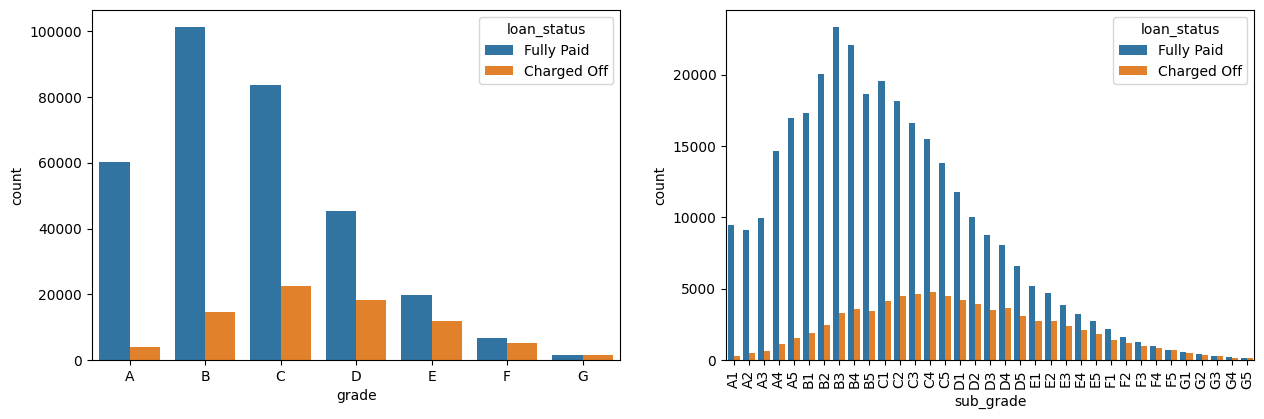

In [113]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
grade = sorted(df.grade.unique().tolist())
sns.countplot(x='grade', data=data, hue='loan_status', order=grade)

plt.subplot(2, 2, 2)
sub_grade = sorted(df.sub_grade.unique().tolist())
g = sns.countplot(x='sub_grade', data=data, hue='loan_status', order=sub_grade)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

[Text(0, 0, 'vacation'),
 Text(1, 0, 'debt_consolidation'),
 Text(2, 0, 'credit_card'),
 Text(3, 0, 'home_improvement'),
 Text(4, 0, 'small_business'),
 Text(5, 0, 'major_purchase'),
 Text(6, 0, 'other'),
 Text(7, 0, 'medical'),
 Text(8, 0, 'wedding'),
 Text(9, 0, 'car'),
 Text(10, 0, 'moving'),
 Text(11, 0, 'house'),
 Text(12, 0, 'educational'),
 Text(13, 0, 'renewable_energy')]

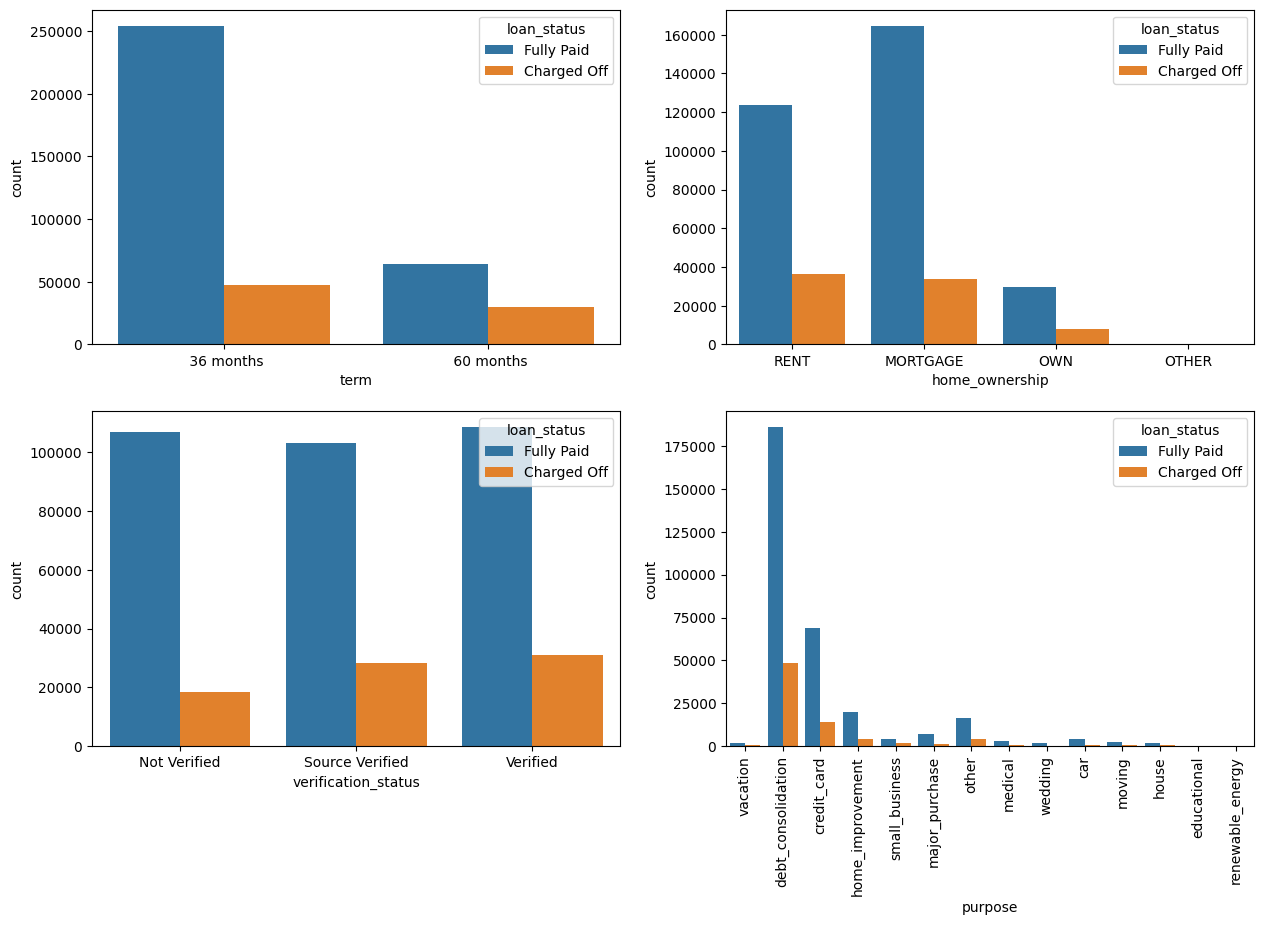

In [114]:
plt.figure(figsize=(15,20))

plt.subplot(4,2,1)
sns.countplot(x='term',data=data,hue='loan_status')

plt.subplot(4,2,2)
sns.countplot(x='home_ownership',data=data,hue='loan_status')

plt.subplot(4,2,3)
sns.countplot(x='verification_status',data=data,hue='loan_status')

plt.subplot(4,2,4)
g=sns.countplot(x='purpose',data=data,hue='loan_status')
g.set_xticklabels(g.get_xticklabels(),rotation=90)

Manager and Teacher are the most afforded loan on titles


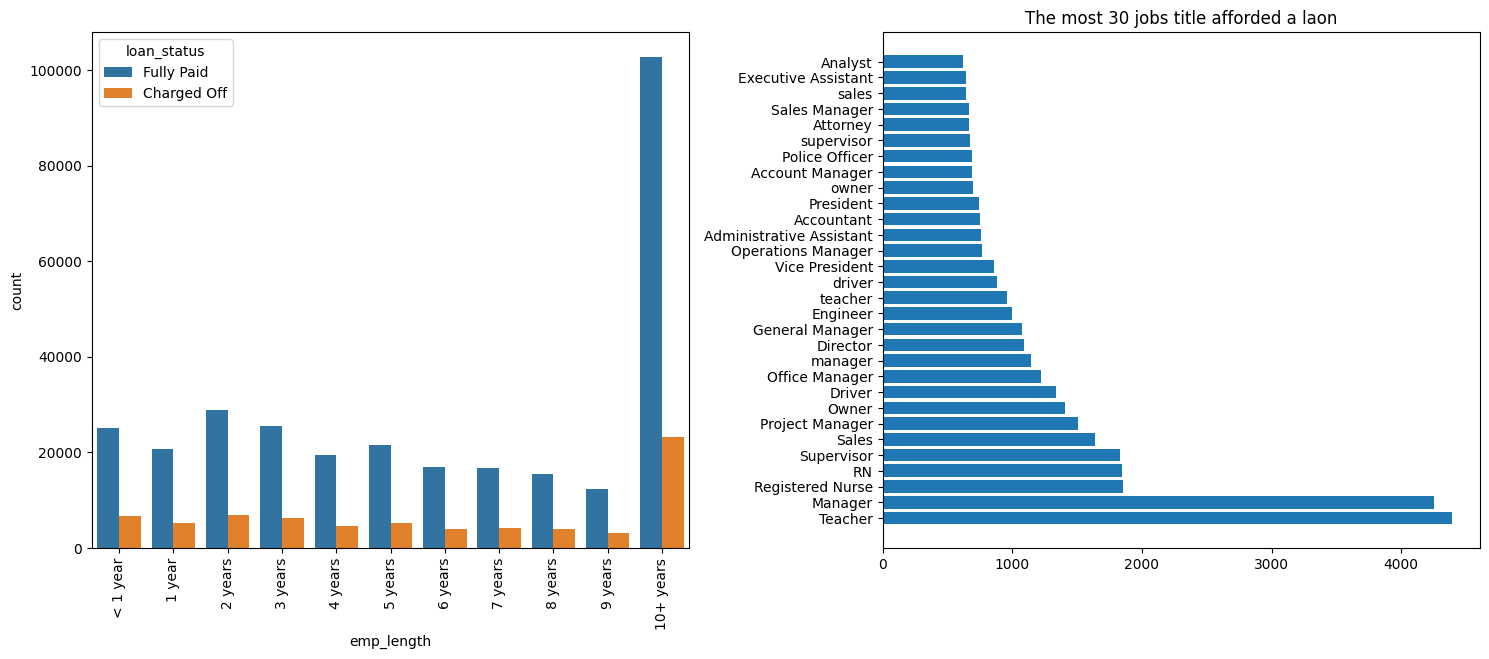

In [115]:
plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
          '6 years', '7 years', '8 years', '9 years', '10+ years',]
g=sns.countplot(x='emp_length',data=data,hue='loan_status',order=order)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.subplot(2,2,2)
plt.barh(data.emp_title.value_counts()[:30].index,data.emp_title.value_counts()[:30])
plt.title("The most 30 jobs title afforded a laon")
plt.tight_layout()

### **Feature Engineering**


In [116]:
#below are high outlier columns.
#We dont want to delete these records since someone whos taken a loan for the first time may have low bankruptucy record
#so im just flagging anything more than 0 as 1

def pub_rec(number):
    if number == 0.0:
        return 0
    else:
        return 1

def mort_acc(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number


def pub_rec_bankruptcies(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number


In [117]:
data['pub_rec']=data.pub_rec.apply(pub_rec)
data['mort_acc']=data.mort_acc.apply(mort_acc)
data['pub_rec_bankruptcies']=data.pub_rec_bankruptcies.apply(pub_rec_bankruptcies)

<Axes: xlabel='pub_rec_bankruptcies', ylabel='count'>

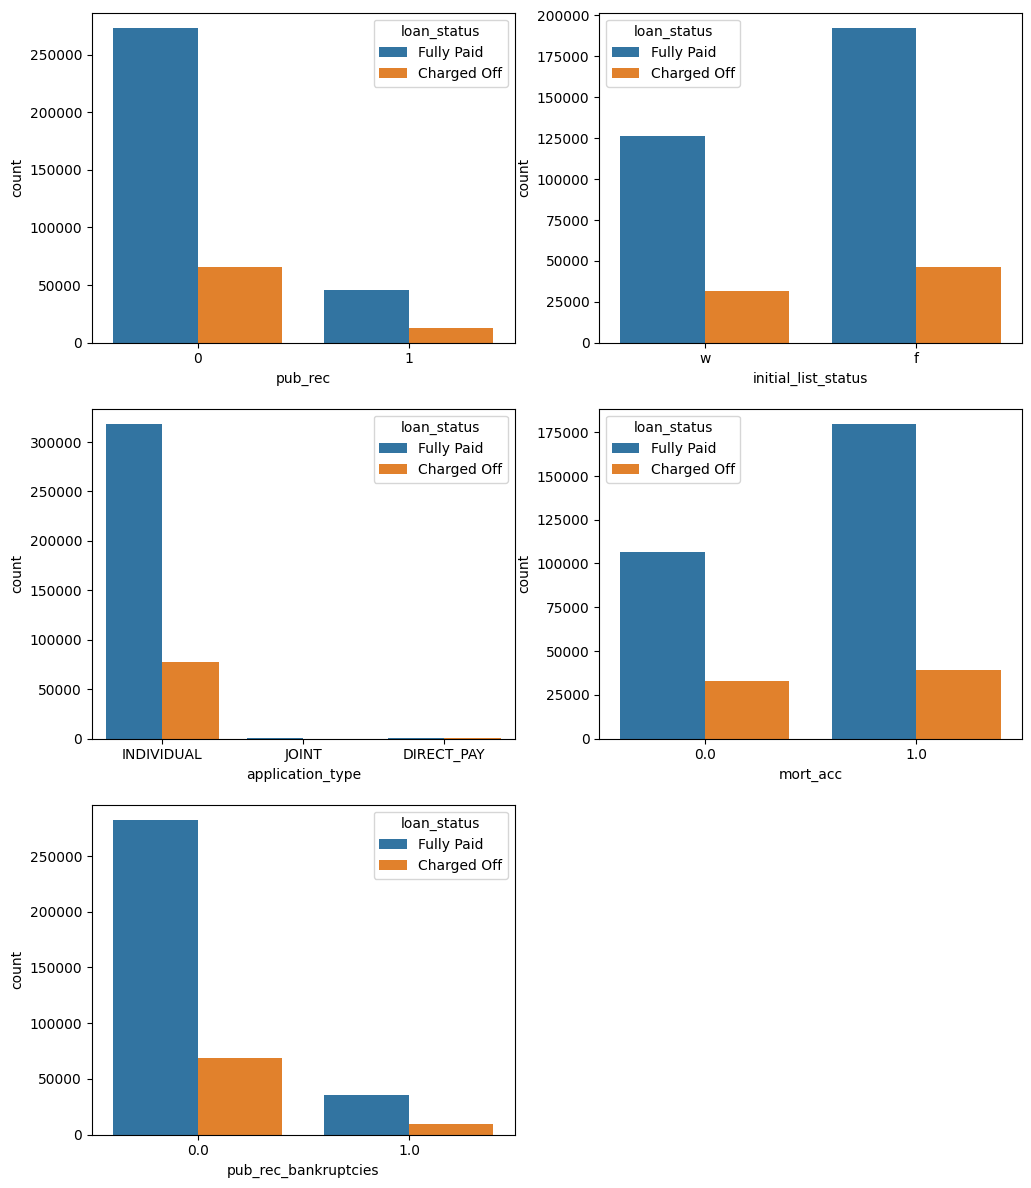

In [118]:
plt.figure(figsize=(12,30))

plt.subplot(6,2,1)
sns.countplot(x='pub_rec',data=data,hue='loan_status')

plt.subplot(6,2,2)
sns.countplot(x='initial_list_status',data=data,hue='loan_status')

plt.subplot(6,2,3)
sns.countplot(x='application_type',data=data,hue='loan_status')

plt.subplot(6,2,4)
sns.countplot(x='mort_acc',data=data,hue='loan_status')

plt.subplot(6,2,5)
sns.countplot(x='pub_rec_bankruptcies',data=data,hue='loan_status')

In [119]:
# Mapping of target variable
data['loan_status']=data.loan_status.map({'Fully Paid':0, 'Charged Off':1})

In [120]:
data.isnull().sum()/len(data)*100

,0
loan_amnt,0.000000
term,0.000000
int_rate,0.000000
grade,0.000000
sub_grade,0.000000
emp_title,5.789208
emp_length,4.621115
home_ownership,0.000000
annual_inc,0.000000
verification_status,0.000000


In [121]:
#Mean Target Imputaion

data.groupby(by='total_acc').mean(numeric_only=True)

,loan_amnt,int_rate,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies
total_acc,,,,,,,,,,,
2.0,6672.222222,15.801111,64277.777778,0.222222,2.279444,1.611111,0.000000,2860.166667,53.527778,0.000000,0.000000
3.0,6042.966361,15.615566,41270.753884,0.220183,6.502813,2.611621,0.033639,3382.807339,49.991022,0.046243,0.015480
4.0,7587.399031,15.069491,42426.565969,0.214055,8.411963,3.324717,0.033118,4874.231826,58.477400,0.062140,0.019672
5.0,7845.734714,14.917564,44394.098003,0.203156,10.118328,3.921598,0.055720,5475.253452,56.890311,0.090789,0.039187
6.0,8529.019843,14.651752,48470.001156,0.215874,11.222542,4.511119,0.076634,6546.374957,57.812483,0.121983,0.050947
7.0,9350.283611,14.415810,50623.501002,0.211200,11.829829,5.093169,0.087618,7363.941588,56.787540,0.171014,0.059423
8.0,9788.345760,14.271851,52571.393657,0.217707,12.684623,5.576887,0.108481,7850.161603,57.348173,0.219463,0.076995
9.0,10042.600597,14.244870,52572.312693,0.213141,13.296349,6.028765,0.121031,8205.770041,56.583065,0.250373,0.088472
10.0,10487.255605,14.109811,55751.004093,0.205553,14.004592,6.466111,0.121741,9124.531283,57.029202,0.275148,0.089615


In [122]:
total_acc_avg=data.groupby(by='total_acc')['mort_acc'].mean()
# saving mean of mort_acc according to total_acc_avg

In [123]:
def fill_mort_acc(total_acc,mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc].round()
    else:
        return mort_acc

In [124]:
data['mort_acc']=data.apply(lambda x: fill_mort_acc(x['total_acc'],x['mort_acc']),axis=1)

In [125]:
data.isnull().sum()/len(data)*100

,0
loan_amnt,0.000000
term,0.000000
int_rate,0.000000
grade,0.000000
sub_grade,0.000000
emp_title,5.789208
emp_length,4.621115
home_ownership,0.000000
annual_inc,0.000000
verification_status,0.000000


In [126]:
# Current no. of rows
data.shape

(396030, 26)

In [127]:
# Dropping rows with null values
data.dropna(inplace=True)

In [128]:
# Remaining no. of rows
data.shape

(370621, 26)

### **Outlier Detection & Treatment**

In [129]:
numerical_data=data.select_dtypes(include='number')
num_cols=numerical_data.columns
len(num_cols)

12

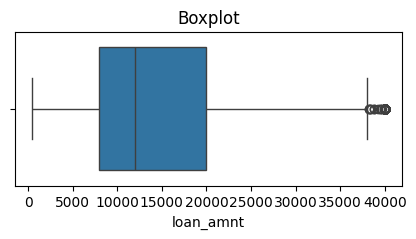

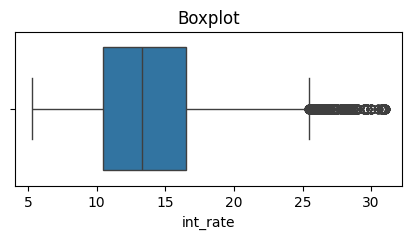

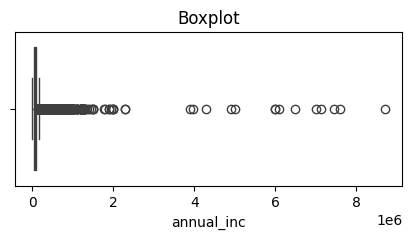

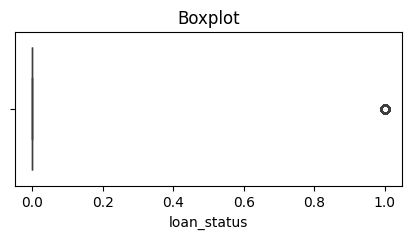

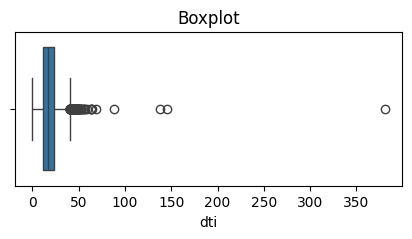

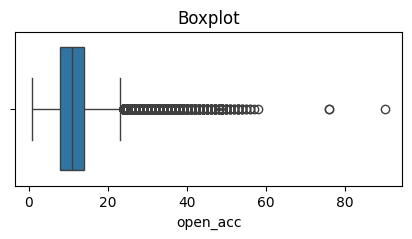

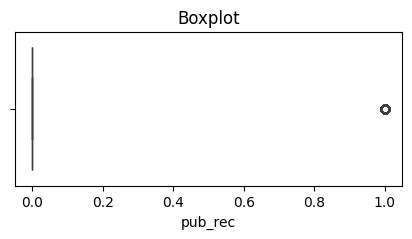

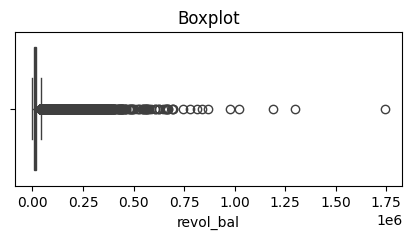

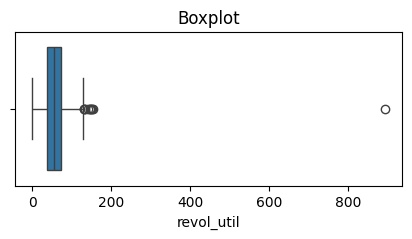

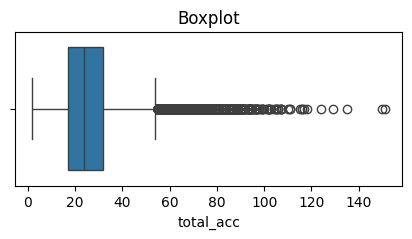

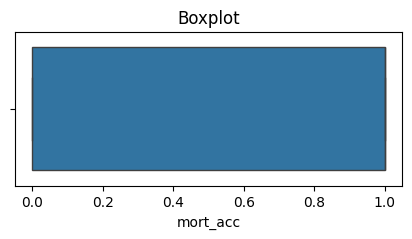

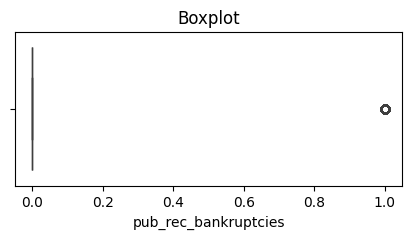

In [130]:
def box_plot(col):
    plt.figure(figsize=(5,2))
    sns.boxplot(x=data[col])
    plt.title('Boxplot')
    plt.show()

for col in num_cols:
    box_plot(col)

In [131]:
for col in num_cols:
    mean=data[col].mean()
    std=data[col].std()

    upper_limit=mean+3*std
    lower_limit=mean-3*std

    data=data[(data[col]<upper_limit) & (data[col]>lower_limit)]

data.shape

(354518, 26)

### **Data Preprocesing**

In [132]:
# Term
data.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [133]:
term_values={' 36 months': 36, ' 60 months':60}
data['term'] = data.term.map(term_values)

In [134]:
# Initial List Status
data['initial_list_status'].unique()

array(['w', 'f'], dtype=object)

In [135]:
list_status = {'w': 0, 'f': 1}
data['initial_list_status'] = data.initial_list_status.map(list_status)

In [136]:
# Let's fetch ZIP from address and then drop the remaining details -
data['zip_code'] = data.address.apply(lambda x: x[-5:])

In [137]:
data['zip_code'].value_counts(normalize=True)*100

,proportion
zip_code,
70466,14.382062
30723,14.277413
22690,14.268387
48052,14.127068
00813,11.610130
29597,11.537073
05113,11.516764
93700,2.774753
11650,2.772779


In [138]:
# Dropping some variables which we can let go for now
data.drop(columns=['issue_d', 'emp_title', 'title', 'sub_grade',
                   'address', 'earliest_cr_line', 'emp_length'],
                   axis=1, inplace=True)

**One-hot Encoding**

In [139]:
dummies=['purpose', 'zip_code', 'grade', 'verification_status', 'application_type', 'home_ownership']
data=pd.get_dummies(data,columns=dummies,drop_first=True)

In [140]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

data.head()

,loan_amnt,term,int_rate,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mort_acc,pub_rec_bankruptcies,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,zip_code_05113,zip_code_11650,zip_code_22690,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,verification_status_Source Verified,verification_status_Verified,application_type_INDIVIDUAL,application_type_JOINT,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,10000.0,36,11.44,117000.0,0,26.24,16.0,0,36369.0,41.8,25.0,0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True
1,8000.0,36,11.99,65000.0,0,22.05,17.0,0,20131.0,53.3,27.0,1,1.0,0.0,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False
2,15600.0,36,10.49,43057.0,0,12.79,13.0,0,11987.0,92.2,26.0,1,0.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,True
3,7200.0,36,6.49,54000.0,0,2.60,6.0,0,5472.0,21.5,13.0,1,0.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
4,24375.0,60,17.27,55000.0,1,33.95,13.0,0,24584.0,69.8,43.0,1,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False


In [141]:
data.shape

(354518, 49)

**Data Preparation for Modelling**

In [142]:
X=data.drop('loan_status',axis=1)
y=data['loan_status']

In [143]:
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.30,stratify=y,random_state=42)

In [144]:
print(X_train.shape)
print(X_test.shape)

(248162, 48)
(106356, 48)


**MinMaxScaler**

For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum.

MinMaxScaler preserves the shape of the original distribution. It doesn’t meaningfully change the information embedded in the original data.

In [145]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Logistic Regression**

In [146]:
logreg=LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [147]:
y_pred = logreg.predict(X_test)
print('Accuracy of Logistic Regression Classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logistic Regression Classifier on test set: 0.890


**Confusion Matrix**

In [148]:
confusion_matrix=confusion_matrix(y_test,y_pred)
print(confusion_matrix)

[[85374   514]
 [11136  9332]]


**Classification Report**


In [149]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.94     85888
           1       0.95      0.46      0.62     20468

    accuracy                           0.89    106356
   macro avg       0.92      0.72      0.78    106356
weighted avg       0.90      0.89      0.87    106356



**ROC Curve -**

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

- True Positive Rate
- False Positive Rate

True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows:
- TPR=(TP)/(TP+FN)

False Positive Rate (FPR) is defined as follows:
- FPR=(FP)/(FP+TN)

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.

**AUC (Area under the ROC Curve) -**

AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).

AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example. For example, given the following examples, which are arranged from left to right in ascending order of logistic regression predictions.

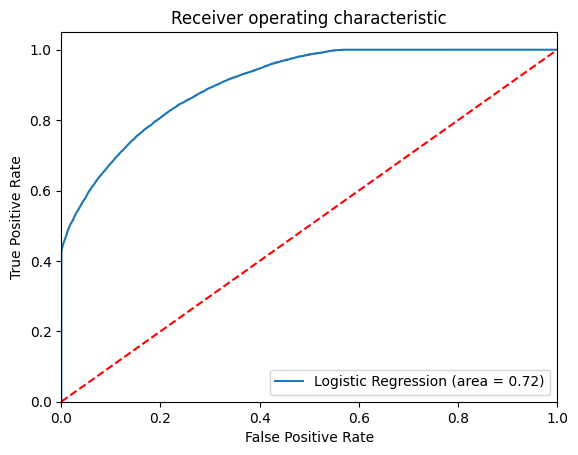

In [150]:
logit_roc_auc=roc_auc_score(y_test,logreg.predict(X_test))
fpr,tpr,thresholds=roc_curve(y_test,logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

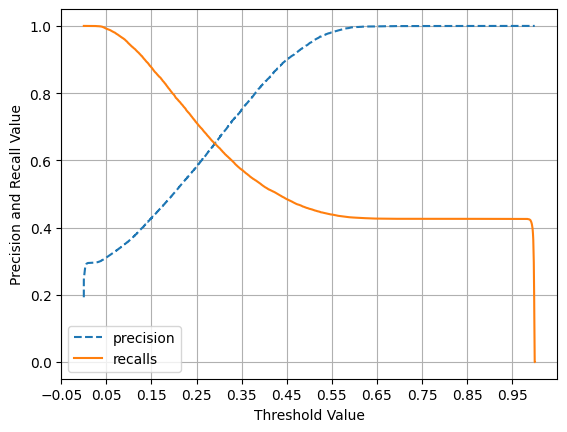

In [151]:
def precission_recall_curve_plot(y_test,pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_c1)

    threshold_boundary = thresholds.shape[0]
    #plot precision
    plt.plot(thresholds,precisions[0:threshold_boundary],linestyle='--',label='precision')
    #plot recall
    plt.plot(thresholds,recalls[0:threshold_boundary],label='recalls')

    start,end=plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))

    plt.xlabel('Threshold Value')
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.grid()
    plt.show()

precission_recall_curve_plot(y_test,logreg.predict_proba(X_test)[:,1])

**Multicollinearity check using Variance Inflation Factor (VIF) -**

Multicollinearity occurs when two or more independent variables are highly correlated with one another in a regression model. Multicollinearity can be a problem in a regression model because we would not be able to distinguish between the individual effects of the independent variables on the dependent variable.

Multicollinearity can be detected via various methods. One such method is Variance Inflation Factor aka VIF. In VIF method, we pick each independent feature and regress it against all of the other independent features. VIF score of an independent variable represents how well the variable is explained by other independent variables.

VIF = 1/1-R2

**Oversampling using SMOTE**

In [156]:
sm=SMOTE(random_state=42)
X_train_res,y_train_res=sm.fit_resample(X_train,y_train.ravel())

In [157]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (400808, 48)
After OverSampling, the shape of train_y: (400808,) 

After OverSampling, counts of label '1': 200404
After OverSampling, counts of label '0': 200404


In [158]:
lr1 = LogisticRegression(max_iter=1000)
lr1.fit(X_train_res, y_train_res)
predictions = lr1.predict(X_test)

# Classification Report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87     85888
           1       0.49      0.81      0.61     20468

    accuracy                           0.80    106356
   macro avg       0.72      0.80      0.74    106356
weighted avg       0.86      0.80      0.82    106356



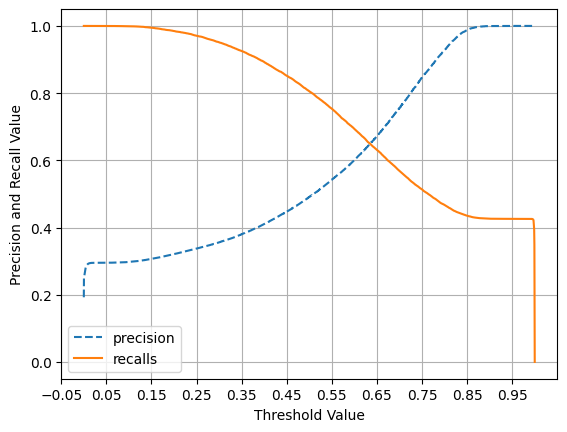

In [159]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr1.predict_proba(X_test)[:,1])

**How to Detect Real Defaulters and Reduce False Positives**

Reducing false positives (approving loans for individuals who might default) and accurately identifying real defaulters is crucial in the lending industry. Here are several strategies to achieve this:

**1. Feature Selection and Engineering:**

- Identify and use relevant features that are strong indicators of creditworthiness, such as credit score, income stability, debt-to-income ratio, and employment history.
- Create new features that might have predictive power, such as the length of credit history or the number of open credit lines.

**2. Advanced Modeling Techniques:**

- Use advanced machine learning algorithms that handle imbalanced datasets well, such as ensemble methods like Random Forest and Gradient Boosting.
- Implement techniques like SMOTE (Synthetic Minority Over-sampling Technique) to oversample the minority class (defaulters) and balance the dataset.

**3. Tuning Model Parameters:**

- Tune model hyperparameters to improve performance, especially focusing on parameters related to handling class imbalance.
- Utilize techniques like Grid Search or Randomized Search to find the best hyperparameters.

**4. Evaluation Metrics:**

- Use appropriate evaluation metrics, such as precision, recall, F1-score, and ROC-AUC, rather than accuracy.
- Focus on maximizing recall to minimize false negatives while keeping precision reasonably high to avoid excessive false positives.

**5. Regular Monitoring and Updating:**

- Regularly monitor the model's performance and update it as the lending landscape changes.
- Implement feedback loops where real-world outcomes are used to retrain and recalibrate the model.

**Playing Safe and Avoiding Loans to High-Risk Applicants:**

**1. Strict Approval Criteria:**

- Establish stringent approval criteria based on thorough analysis of historical default data.
- Avoid lending to individuals with a history of multiple late payments or bankruptcies.

**2. Regulatory Compliance:**

- Adhere to regulatory guidelines and industry best practices to ensure responsible and legal loan disbursal.
- Stay updated with the latest regulations related to lending practices.
Use of Alternative Data:
- Incorporate alternative data sources, such as social media profiles or utility bill payment history, to assess creditworthiness.

**3. Continuous Risk Assessment:**
- Implement continuous risk assessment mechanisms that monitor borrowers' financial behavior even after loan approval.
- Utilize modern technologies like machine learning algorithms to detect early signs of financial distress among borrowers.

**4. Collaborate with Credit Bureaus:**

- Collaborate with credit bureaus to access comprehensive credit reports and credit scores for a more accurate assessment of applicants' creditworthiness.

## **Insights:**
- The majority of the home ownership status provided by the borrower during registration or obtained from the credit report is MORTGAGE.
- The largest number of people were assigned to the B group by LOANTAP.
- The popular loan term is 36 months.
- More loans were approved for people with the longest employment years.
TEACHER & MANAGER were awarded more loans. The accuracy after oversampling using SMOTE is 80%.


## **Recommendations:**
- Provide more options for the term period so customers can make payments according to their incomes.
- Give an equal number of loans to high-paying job title customers; expectations for full payment can be higher.
- Approve loans for EDUCATION, MEDICAL & other important purposes with Strict Approval Criteria to create loyalty with customers with the bank.